In [1]:
import pandas as pd
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from collections import OrderedDict
from datetime import datetime, timedelta

In [2]:
def make_six_digit_list(input_list):
    six_digit_list = []

    for item in input_list:
        # 현재 항목의 길이를 확인
        item_str = str(item)
        item_len = len(item_str)

        if item_len < 6:
            # 6자리가 안되는 항목은 앞에 0을 채워서 6자리로 만듭니다.
            zero_padding = '0' * (6 - item_len)
            six_digit_item = zero_padding + item_str
            six_digit_list.append(six_digit_item)
        else:
            # 이미 6자리인 경우 그대로 유지
            six_digit_list.append(item_str)

    return six_digit_list

def filter_df(df): #데이터프레임 필터링
    # 첫 번째 열에서 같은 값을 가진 행의 수를 계산합니다.
    row_counts = df['Ticker'].value_counts()

    # 가장 많은 행의 수를 찾습니다.
    max_row_count = row_counts.max()

    # 가장 많은 행의 수에 해당하는 행만 분류합니다.
    filtered = pd.DataFrame(df[df['Ticker'].isin(row_counts[row_counts == max_row_count].index)])

    return filtered

def Prediction():
    pred_df = pd.read_csv('KRX/Scrap_Pred/StockData_Pred_240311.csv',low_memory=False)
    
    targer_day = datetime(year=2024,month=3,day=11)
    end_info_day = (targer_day - timedelta(days=1))

    filter_pred= filter_df(pred_df)

    # 예측에 필요한 데이터 
    pred_ticker = list(OrderedDict.fromkeys(filter_pred['Ticker'])) #종목코드 저장

    # 불필요한 데이터 삭제
    filter_pred = filter_pred.drop({'Ticker','Date','Change'},axis=1) #종목코드, 날자, 상승율 삭제

    model_1 = tf.keras.models.load_model("GRU_128_64_32_2_KOSPI_TI_3%.h5")

    Pred = model_1.predict(filter_pred).round(2)
    # 5% 이상 오를 종목 식별
    rising_stocks = [ticker for i, ticker in enumerate(pred_ticker) if Pred[i] > 0.9]
    rising_stocks = list(map(str, rising_stocks))
    result = list(set(rising_stocks))
    result = make_six_digit_list(result)
    high_52 = add_52_week_high_info(result,end_info_day)
    final_result = high_52.head(5)
    return final_result

def add_52_week_high_info(series,end_info_day):
    df = pd.DataFrame(series, columns=['Code'])
    high_52_week_list = []
    change_percentage_list = []
    average_volume_5_days = []

    for stock_code in series:
    # 10일 전 날짜 계산
        high_52_date = (end_info_day - timedelta(days=375)).strftime('%Y-%m-%d')

        # FinanceDataReader를 사용하여 주식 데이터 가져오기
        stock_data = fdr.DataReader(stock_code, start=high_52_date, end=end_info_day).reset_index()
        stock_data['Volume'] = stock_data['Volume'] * ((stock_data['High'] + stock_data['Low']) / 2)

        # 52주 최고가 계산
        rolling_result = stock_data['High'].rolling(window=250).max()
        
        # 최근 종가 대비 52주 최고가 대비 변동율 계산
        change_percentage = round((stock_data['Close'].shift(1) - rolling_result) / rolling_result, 3)

        # 거래량(거래대금)의 평균 계산
        stock_data = stock_data.tail(5)
        average_volume = int(stock_data['Volume'].mean())
        
        high_52_week_list.append(rolling_result.tail(1))
        change_percentage_list.append(change_percentage.tail(1))
        average_volume_5_days.append(average_volume)

    df['52주 최고가'] = high_52_week_list
    df['52주 최고가 대비 변동율'] = change_percentage_list
    df['5일 평균 거래대금'] = average_volume_5_days
    #5일 평균 거래량 기준 내림차순
    df = df.sort_values(by='5일 평균 거래대금', ascending=False)

    return df

예측

In [3]:
pred_1 = Prediction()
code_list = pred_1['Code']

3/3 [==============================] - 1s 12ms/step


예측한 결과 확인

              Open    High     Low   Close   Volume   Change
Date                                                        
2024-03-08  126900  132000  123500  127700  2592648  0.02818
2024-03-11  129100  132600  122900  125100  1499224 -0.02036
              Open    High     Low   Close   Volume    Change
Date                                                         
2024-03-08  420500  442500  418000  426000  1764503  0.033981
2024-03-11  421000  424500  411000  414500   471864 -0.026995
             Open    High    Low   Close    Volume    Change
Date                                                        
2024-03-08  80000   98900  79300   98000  12926607  0.226533
2024-03-11  98700  101600  95200  100100   4843910  0.021429
            Open  High   Low  Close    Volume    Change
Date                                                   
2024-03-08  4090  5120  4045   5120  97517006  0.297845
2024-03-11  5720  6430  5480   6220  73790097  0.214844
             Open   High    Low  Close  

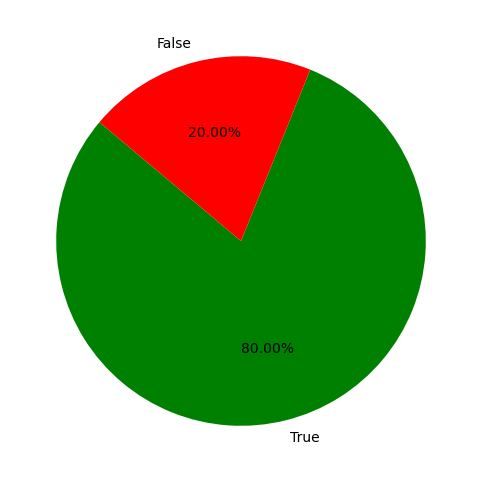

In [4]:
def check_price_increase(stock_codes):
    result = {}
    
    for code in stock_codes:
        df = fdr.DataReader(code, '2024-03-08', '2024-03-11')  # 전날을 포함하도록 날짜 범위 수정
        print(df)
        if len(df) < 2:
            result[code] = False
        else:
            # 전날 종가로부터 당일 고가까지의 변동률 계산
            percentage_change = (df['High'].iloc[-1] - df['Close'].iloc[-2]) / df['Close'].iloc[-2] * 100

            # 변동률이 5% 이상인 경우 참, 그 외에는 거짓으로 설정
            if percentage_change >= 3.3:
                result[code] = True
            else:
                result[code] = False
    return result

result_TF = check_price_increase(code_list)
result_TF = list(result_TF.values())
# True와 False의 개수를 세어 비율을 계산
true_count = sum(result_TF)
false_count = len(result_TF) - true_count
# 비율을 파이그래프로 표현
labels = ['True', 'False']
sizes = [true_count, false_count]
colors = ['green', 'red']
# 파이차트 그리기
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=140)
# 그래프 표시
plt.show() 